In [1]:
"""
Homework 3: Understanding CGP code and implementing SGD + Momentum 
Author: Varun Aggarwal
Last Modified: 27 Jan 2022
"""

import random
import numpy as np
import sys
import operator
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("..")
from ComputationalGraphPrimer import *

In [2]:
## Modified from one_neuron_classifier.py
seed = 0           
random.seed(seed)
np.random.seed(seed)

In [3]:
# inherited class 
class cgpSuperCharged(ComputationalGraphPrimer):
    def __init__(self, mu=0.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mu = mu
        self.step_hist = 0
        
    def backprop_and_update_params_one_neuron_model(self, y_error_avg, data_tuple_avg, deriv_sigmoid_avg):
        """
            This function is copied over from 
            ComputationalGraphPrimer.py Version 1.0.8

            Modifications:
            -----------
            -----------
            -----------
            -----------
        """
        input_vars = self.independent_vars
        vals_for_input_vars_dict =  dict(zip(input_vars, list(data_tuple_avg)))
        vals_for_learnable_params = self.vals_for_learnable_params
        
        for i,param in enumerate(self.vals_for_learnable_params):
            ## calculate the next step in the parameter hyperplane
            
            # representing in same notation as the HW text
            g_tp1 = y_error_avg * vals_for_input_vars_dict[input_vars[i]] * deriv_sigmoid_avg 
            
            step = self.mu*self.step_hist[i] + self.learning_rate*g_tp1   
            self.vals_for_learnable_params[param] += step
            
            # update step_hist
            self.step_hist[i] = step
        
        ## Bias momentum step
        self.bias_hist = self.mu*self.bias_hist + self.learning_rate * y_error_avg * deriv_sigmoid_avg  
        self.bias += self.bias_hist
    
    def run_training_loop_one_neuron_model(self, training_data):
        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}
        self.bias = random.uniform(0,1)

        class DataLoader:
            """
            The data loader's job is to construct a batch of randomly chosen samples from the
            training data.  But, obviously, it must first associate the class labels 0 and 1 with
            the training data supplied to the constructor of the DataLoader.   NOTE:  The training
            data is generated in the Examples script by calling 'cgp.gen_training_data()' in the
            ****Utility Functions*** section of this file.  That function returns two normally
            distributed set of number with different means and variances.  One is for key value '0'
            and the other for the key value '1'.  The constructor of the DataLoader associated a'
            class label with each sample separately.
            """
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]
            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])
            def _getitem(self):    
                cointoss = random.choice([0,1])
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            
            def getbatch(self):
                batch_data,batch_labels = [],[]
                maxval = 0.0
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]                
                batch = [batch_data, batch_labels]
                return batch                

        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_literations = 0.0
        
        # preparing varibles 
        self.step_hist = list(np.zeros(len(self.learnable_params)))
        self.bias_hist = 0 
        
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            y_preds, deriv_sigmoids =  self.forward_prop_one_neuron_model(data_tuples)
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])
            loss_avg = loss / float(len(class_labels))
            avg_loss_over_literations += loss_avg
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_literations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_literations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_literations))
                avg_loss_over_literations = 0.0
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            deriv_sigmoid_avg = sum(deriv_sigmoids) / float(len(class_labels))
            data_tuple_avg = [sum(x) for x in zip(*data_tuples)]
            data_tuple_avg = list(map(operator.truediv, data_tuple_avg, 
                                     [float(len(class_labels))] * len(class_labels) ))
            self.backprop_and_update_params_one_neuron_model(y_error_avg, data_tuple_avg, deriv_sigmoid_avg)
        
        return loss_running_record  
        
        
cgp = cgpSuperCharged(
       one_neuron_model = True,
       expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
       output_vars = ['xw'],
       dataset_size = 5000,
       learning_rate = 1e-3,
#      learning_rate = 5 * 1e-2,
       training_iterations = 40000,
       batch_size = 8,
       display_loss_how_often = 100,
       debug = True,
      )

cgp_original = ComputationalGraphPrimer(
       one_neuron_model = True,
       expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
       output_vars = ['xw'],
       dataset_size = 5000,
       learning_rate = 1e-3,
#      learning_rate = 5 * 1e-2,
       training_iterations = 40000,
       batch_size = 8,
       display_loss_how_often = 100,
       debug = True,
      )

In [4]:
cgp.parse_expressions()
training_data = cgp.gen_training_data()
loss_running_record_mu = cgp.run_training_loop_one_neuron_model( training_data )

cgp_original.parse_expressions()
training_data = cgp_original.gen_training_data()
loss_running_record = cgp_original.run_training_loop_one_neuron_model( training_data )



all variables: {'xc', 'xd', 'xb', 'xa', 'xw'}


learnable params: ['ab', 'bc', 'cd', 'ac']


dependencies: {'xw': ['xa', 'xb', 'xc', 'xd']}


expressions dict: {'xw': 'ab*xa+bc*xb+cd*xc+ac*xd'}


independent vars: ['xc', 'xd', 'xb', 'xa']


leads_to dictionary: {'xc': {'xw'}, 'xd': {'xw'}, 'xb': {'xw'}, 'xa': {'xw'}, 'xw': set()}
[iter=1]  loss = 0.0036
[iter=101]  loss = 0.2938
[iter=201]  loss = 0.2986
[iter=301]  loss = 0.3137
[iter=401]  loss = 0.3148
[iter=501]  loss = 0.2942
[iter=601]  loss = 0.3006
[iter=701]  loss = 0.3027
[iter=801]  loss = 0.2971
[iter=901]  loss = 0.3048
[iter=1001]  loss = 0.3100
[iter=1101]  loss = 0.3075
[iter=1201]  loss = 0.2838
[iter=1301]  loss = 0.2843
[iter=1401]  loss = 0.2951
[iter=1501]  loss = 0.3168
[iter=1601]  loss = 0.2891
[iter=1701]  loss = 0.2967
[iter=1801]  loss = 0.2871
[iter=1901]  loss = 0.2843
[iter=2001]  loss = 0.2880
[iter=2101]  loss = 0.2964
[iter=2201]  loss = 0.2951
[iter=2301]  loss = 0.2970
[iter=2401]  loss = 0.2836
[it

[iter=29101]  loss = 0.2241
[iter=29201]  loss = 0.2246
[iter=29301]  loss = 0.2221
[iter=29401]  loss = 0.2224
[iter=29501]  loss = 0.2211
[iter=29601]  loss = 0.2211
[iter=29701]  loss = 0.2207
[iter=29801]  loss = 0.2242
[iter=29901]  loss = 0.2232
[iter=30001]  loss = 0.2215
[iter=30101]  loss = 0.2205
[iter=30201]  loss = 0.2186
[iter=30301]  loss = 0.2228
[iter=30401]  loss = 0.2222
[iter=30501]  loss = 0.2240
[iter=30601]  loss = 0.2248
[iter=30701]  loss = 0.2215
[iter=30801]  loss = 0.2227
[iter=30901]  loss = 0.2221
[iter=31001]  loss = 0.2231
[iter=31101]  loss = 0.2241
[iter=31201]  loss = 0.2235
[iter=31301]  loss = 0.2229
[iter=31401]  loss = 0.2226
[iter=31501]  loss = 0.2242
[iter=31601]  loss = 0.2199
[iter=31701]  loss = 0.2221
[iter=31801]  loss = 0.2227
[iter=31901]  loss = 0.2252
[iter=32001]  loss = 0.2217
[iter=32101]  loss = 0.2217
[iter=32201]  loss = 0.2229
[iter=32301]  loss = 0.2234
[iter=32401]  loss = 0.2198
[iter=32501]  loss = 0.2247
[iter=32601]  loss =

[iter=18001]  loss = 0.2349
[iter=18101]  loss = 0.2307
[iter=18201]  loss = 0.2342
[iter=18301]  loss = 0.2304
[iter=18401]  loss = 0.2321
[iter=18501]  loss = 0.2321
[iter=18601]  loss = 0.2307
[iter=18701]  loss = 0.2285
[iter=18801]  loss = 0.2346
[iter=18901]  loss = 0.2364
[iter=19001]  loss = 0.2326
[iter=19101]  loss = 0.2312
[iter=19201]  loss = 0.2311
[iter=19301]  loss = 0.2344
[iter=19401]  loss = 0.2304
[iter=19501]  loss = 0.2304
[iter=19601]  loss = 0.2313
[iter=19701]  loss = 0.2310
[iter=19801]  loss = 0.2305
[iter=19901]  loss = 0.2285
[iter=20001]  loss = 0.2306
[iter=20101]  loss = 0.2322
[iter=20201]  loss = 0.2290
[iter=20301]  loss = 0.2306
[iter=20401]  loss = 0.2306
[iter=20501]  loss = 0.2269
[iter=20601]  loss = 0.2294
[iter=20701]  loss = 0.2324
[iter=20801]  loss = 0.2306
[iter=20901]  loss = 0.2333
[iter=21001]  loss = 0.2278
[iter=21101]  loss = 0.2293
[iter=21201]  loss = 0.2307
[iter=21301]  loss = 0.2305
[iter=21401]  loss = 0.2304
[iter=21501]  loss =

(0.2, 0.3)

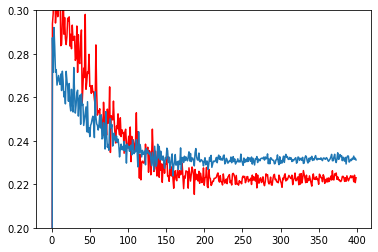

In [8]:
plt.figure()     
plt.plot(loss_running_record_mu, color="red") 
plt.plot(loss_running_record)
plt.ylim(0.2,0.3)